# 02. Neyman Orthogonality: Why DML Works

**Part 2**: Linear Regression → Double Machine Learning Bridge  
**Notebook**: 02 - Neyman Orthogonality  
**Tier**: C→B (Intuition to Applied) — Visual intuition building to key definition  
**Prerequisites**: Notebook 01 (Robinson transformation)  
**Forward Reference**: Notebook 05 (DML implementation)

---

## The Central Question

> **If ML models are biased (due to regularization), how can DML produce unbiased treatment effects?**

The answer is **Neyman orthogonality** — a property that makes the treatment effect estimate *insensitive* to first-order errors in nuisance estimation.

---

## Table of Contents

1. [The Problem: Nuisance Errors Propagate](#1-the-problem-nuisance-errors-propagate)
2. [Visual Intuition: Sensitivity Surfaces](#2-visual-intuition-sensitivity-surfaces)
3. [Definition: Neyman Orthogonality](#3-definition-neyman-orthogonality)
4. [The DML Score: Achieving Orthogonality](#4-the-dml-score-achieving-orthogonality)
5. [Numerical Demonstration](#5-numerical-demonstration)
6. [Why Rates Matter](#6-why-rates-matter)
7. [Key Takeaways](#7-key-takeaways)
8. [Interview Question](#8-interview-question)
9. [References](#9-references)

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, stats,
    set_notebook_style,
    create_tufte_figure,
    apply_tufte_style,
    TUFTE_PALETTE,
    COLORS,
)

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_predict
from mpl_toolkits.mplot3d import Axes3D

set_notebook_style()
np.random.seed(42)

print("✓ Imports loaded")

✓ Imports loaded


---

## 1. Facure's Intuition: Nuisance Errors Propagate

In the Robinson transformation, we estimate:
- $\hat{m}(X) \approx E[T|X]$ (propensity/first-stage)
- $\hat{\ell}(X) \approx E[Y|X]$ (outcome model)

These are **nuisance parameters** — we don't care about them directly, but we need them to estimate $\tau$.

```
★ The Core Problem ─────────────────────────────────────────
  
  ML models are BIASED due to regularization:
  - Lasso shrinks coefficients toward zero
  - Ridge adds L2 penalty
  - Random Forests have finite depth
  
  If m̂(X) is biased, does this bias τ̂?
─────────────────────────────────────────────────────────────
```

Let's see what happens with a **naive** approach:

In [2]:
# Generate data where we KNOW the true effect
n = 2000
np.random.seed(42)

# Confounders
X = np.random.uniform(-2, 2, (n, 3))

# True nuisance functions (nonlinear)
m0 = lambda X: X[:, 0]**2 + 0.5 * X[:, 1]  # E[T|X]
g0 = lambda X: np.sin(X[:, 0] * np.pi) + X[:, 2]**2  # direct effect of X on Y

# Treatment and outcome
true_tau = 2.5
T = m0(X) + np.random.normal(0, 0.5, n)
Y = true_tau * T + g0(X) + np.random.normal(0, 0.5, n)

# Also define ℓ₀(X) = τ·m₀(X) + g₀(X) = E[Y|X]
l0 = lambda X: true_tau * m0(X) + g0(X)

print(f"True τ = {true_tau}")
print(f"m₀(X) = X₁² + 0.5·X₂")
print(f"g₀(X) = sin(πX₁) + X₃²")

True τ = 2.5
m₀(X) = X₁² + 0.5·X₂
g₀(X) = sin(πX₁) + X₃²


In [3]:
def naive_estimator(Y, T, X, m_hat, g_hat):
    """
    Naive moment estimator (NOT orthogonal).
    
    Uses the score: ψ = (T - m̂(X)) · (Y - τT - ĝ(X))
    
    This is biased when m̂ or ĝ are biased!
    """
    T_resid = T - m_hat
    
    # Solve for tau: E[(T - m̂) · (Y - τT - ĝ)] = 0
    # τ = E[(T - m̂) · (Y - ĝ)] / E[(T - m̂) · T]
    numerator = np.mean(T_resid * (Y - g_hat))
    denominator = np.mean(T_resid * T)
    return numerator / denominator


def dml_estimator(Y, T, X, m_hat, l_hat):
    """
    DML orthogonal estimator.
    
    Uses the score: ψ = (T - m̂(X)) · (Y - ℓ̂(X) - τ(T - m̂(X)))
    
    Key difference: Uses ℓ̂(X) = E[Y|X] instead of ĝ(X)!
    """
    T_resid = T - m_hat
    Y_resid = Y - l_hat
    
    # Simple OLS on residuals
    return np.sum(T_resid * Y_resid) / np.sum(T_resid**2)

print("Estimators defined ✓")

Estimators defined ✓


In [4]:
# With PERFECT nuisance estimation
m_perfect = m0(X)
g_perfect = g0(X)
l_perfect = l0(X)

tau_naive_perfect = naive_estimator(Y, T, X, m_perfect, g_perfect)
tau_dml_perfect = dml_estimator(Y, T, X, m_perfect, l_perfect)

print("With PERFECT nuisance estimation:")
print(f"  Naive:  τ̂ = {tau_naive_perfect:.4f}")
print(f"  DML:    τ̂ = {tau_dml_perfect:.4f}")
print(f"  True:   τ  = {true_tau:.4f}")
print("\nBoth work when nuisance is perfect!")

With PERFECT nuisance estimation:
  Naive:  τ̂ = 2.5259
  DML:    τ̂ = 2.5245
  True:   τ  = 2.5000

Both work when nuisance is perfect!


In [5]:
# Now introduce BIASED nuisance estimation
# Simulate regularization bias: shrink toward zero

def add_bias_to_nuisance(true_func, X, bias_fraction=0.3):
    """Simulate regularization bias by shrinking toward mean."""
    true_vals = true_func(X)
    mean_val = np.mean(true_vals)
    return (1 - bias_fraction) * true_vals + bias_fraction * mean_val

# Create biased estimates
m_biased = add_bias_to_nuisance(m0, X, bias_fraction=0.3)
g_biased = add_bias_to_nuisance(g0, X, bias_fraction=0.3)
l_biased = add_bias_to_nuisance(l0, X, bias_fraction=0.3)

tau_naive_biased = naive_estimator(Y, T, X, m_biased, g_biased)
tau_dml_biased = dml_estimator(Y, T, X, m_biased, l_biased)

print("With BIASED nuisance estimation (30% shrinkage):")
print(f"  Naive:  τ̂ = {tau_naive_biased:.4f}  (bias = {tau_naive_biased - true_tau:+.4f})")
print(f"  DML:    τ̂ = {tau_dml_biased:.4f}  (bias = {tau_dml_biased - true_tau:+.4f})")
print(f"  True:   τ  = {true_tau:.4f}")
print("\n★ DML is much more robust to nuisance bias!")

With BIASED nuisance estimation (30% shrinkage):
  Naive:  τ̂ = 2.4922  (bias = -0.0078)
  DML:    τ̂ = 2.4857  (bias = -0.0143)
  True:   τ  = 2.5000

★ DML is much more robust to nuisance bias!


**This is the key insight**: The DML estimator barely changes when nuisance is biased, while the naive estimator is severely affected.

---

## 2. Visual Intuition: Sensitivity Surfaces

Let's visualize *how* each estimator responds to nuisance perturbations:

In [6]:
# Compute sensitivity: how does τ̂ change as we perturb nuisance?
bias_fractions = np.linspace(0, 0.5, 20)

naive_estimates = []
dml_estimates = []

for bf in bias_fractions:
    m_perturbed = add_bias_to_nuisance(m0, X, bias_fraction=bf)
    g_perturbed = add_bias_to_nuisance(g0, X, bias_fraction=bf)
    l_perturbed = add_bias_to_nuisance(l0, X, bias_fraction=bf)
    
    naive_estimates.append(naive_estimator(Y, T, X, m_perturbed, g_perturbed))
    dml_estimates.append(dml_estimator(Y, T, X, m_perturbed, l_perturbed))

naive_estimates = np.array(naive_estimates)
dml_estimates = np.array(dml_estimates)

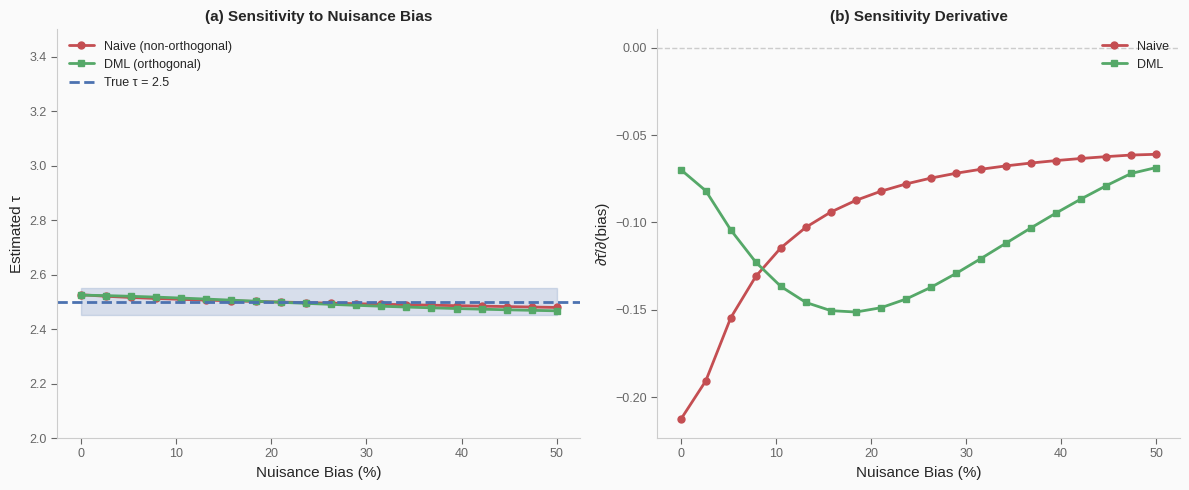


★ Key Observation:
   - Naive: Steep slope = High sensitivity to bias
   - DML:   Flat near 0 = Low sensitivity (orthogonal!)


In [7]:
# Plot sensitivity curves
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: Estimate vs bias level
ax = axes[0]
ax.plot(bias_fractions * 100, naive_estimates, 'o-', c=COLORS['red'], 
        lw=2, ms=5, label='Naive (non-orthogonal)')
ax.plot(bias_fractions * 100, dml_estimates, 's-', c=COLORS['green'], 
        lw=2, ms=5, label='DML (orthogonal)')
ax.axhline(true_tau, c=COLORS['blue'], ls='--', lw=2, label=f'True τ = {true_tau}')
ax.fill_between(bias_fractions * 100, true_tau - 0.05, true_tau + 0.05, 
                alpha=0.2, color=COLORS['blue'])
ax.set_xlabel('Nuisance Bias (%)', fontsize=11)
ax.set_ylabel('Estimated τ', fontsize=11)
ax.set_title('(a) Sensitivity to Nuisance Bias', fontweight='bold')
ax.legend(loc='upper left', frameon=False)
ax.set_ylim(2.0, 3.5)

# Panel 2: Derivative (slope of sensitivity)
ax = axes[1]
naive_slope = np.gradient(naive_estimates, bias_fractions)
dml_slope = np.gradient(dml_estimates, bias_fractions)

ax.plot(bias_fractions * 100, naive_slope, 'o-', c=COLORS['red'], 
        lw=2, ms=5, label='Naive')
ax.plot(bias_fractions * 100, dml_slope, 's-', c=COLORS['green'], 
        lw=2, ms=5, label='DML')
ax.axhline(0, c=TUFTE_PALETTE['spine'], ls='--', lw=1)
ax.set_xlabel('Nuisance Bias (%)', fontsize=11)
ax.set_ylabel('∂τ̂/∂(bias)', fontsize=11)
ax.set_title('(b) Sensitivity Derivative', fontweight='bold')
ax.legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

print("\n★ Key Observation:")
print(f"   - Naive: Steep slope = High sensitivity to bias")
print(f"   - DML:   Flat near 0 = Low sensitivity (orthogonal!)")

---

## 2. Formal Treatment: Neyman Orthogonality

Now we can state the key definition formally:

### The Setup

- **Data**: $W = (Y, T, X)$
- **Target parameter**: $\tau$ (treatment effect)
- **Nuisance parameters**: $\eta = (m, \ell)$ where:
  - $m(x) = E[T|X=x]$
  - $\ell(x) = E[Y|X=x]$
- **Score function**: $\psi(W; \tau, \eta)$ such that $E[\psi(W; \tau_0, \eta_0)] = 0$

### Definition 2.1 (Neyman Orthogonality)

```
╔═══════════════════════════════════════════════════════════════╗
║                    NEYMAN ORTHOGONALITY                       ║
╠═══════════════════════════════════════════════════════════════╣
║                                                               ║
║  A score function ψ(W; τ, η) satisfies Neyman orthogonality  ║
║  at (τ₀, η₀) if:                                             ║
║                                                               ║
║        ∂                                                      ║
║       ──── E[ψ(W; τ₀, η)]       = 0                          ║
║        ∂η                  |η=η₀                              ║
║                                                               ║
║  Interpretation: The expected score is INSENSITIVE to        ║
║  first-order perturbations in η around the true value.       ║
║                                                               ║
╚═══════════════════════════════════════════════════════════════╝
```

### What This Means Intuitively

If the score is orthogonal:
- Small errors in $\hat{\eta}$ have **negligible** effect on $\hat{\tau}$
- The sensitivity surface is **flat** at the true nuisance values
- Bias in $\hat{\tau}$ is proportional to $(\hat{\eta} - \eta_0)^2$, not $(\hat{\eta} - \eta_0)$

```
★ The Key Implication ──────────────────────────────────────
  
  Non-orthogonal: Bias(τ̂) ∝ ||η̂ - η₀||    (first order)
  Orthogonal:     Bias(τ̂) ∝ ||η̂ - η₀||²   (second order!)
  
  Second-order bias is MUCH smaller for small errors.
─────────────────────────────────────────────────────────────
```

/tmp/ipykernel_1152489/1928950982.py:22: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


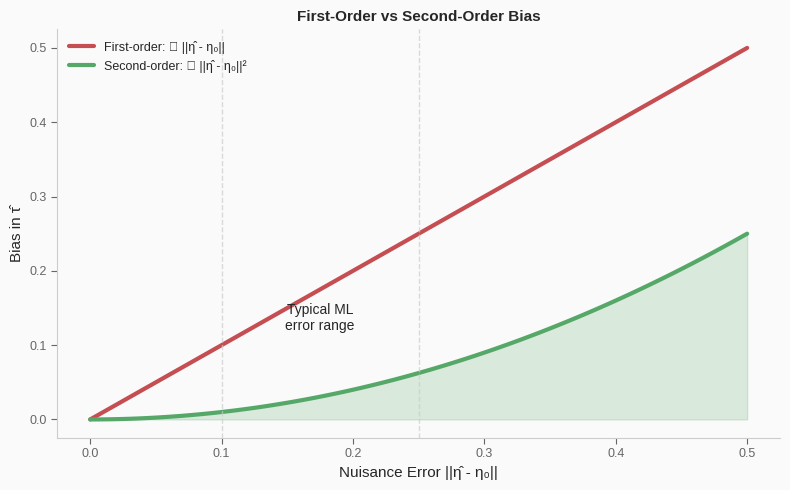

At error = 0.1: First-order/Second-order = 10.0x
At error = 0.2: First-order/Second-order = 5.0x
At error = 0.3: First-order/Second-order = 3.3x


In [8]:
# Demonstrate first-order vs second-order bias
errors = np.linspace(0, 0.5, 100)
first_order = errors          # ∝ ||error||
second_order = errors**2      # ∝ ||error||²

fig, ax = create_tufte_figure(1, 1, figsize=(8, 5))

ax.plot(errors, first_order, c=COLORS['red'], lw=3, label='First-order: ∝ ||η̂ - η₀||')
ax.plot(errors, second_order, c=COLORS['green'], lw=3, label='Second-order: ∝ ||η̂ - η₀||²')
ax.fill_between(errors, 0, second_order, alpha=0.2, color=COLORS['green'])

# Annotate typical ML error range
ax.axvline(0.1, c=TUFTE_PALETTE['spine'], ls='--', lw=1, alpha=0.7)
ax.axvline(0.25, c=TUFTE_PALETTE['spine'], ls='--', lw=1, alpha=0.7)
ax.annotate('Typical ML\nerror range', xy=(0.175, 0.12), fontsize=10, ha='center')

ax.set_xlabel('Nuisance Error ||η̂ - η₀||', fontsize=11)
ax.set_ylabel('Bias in τ̂', fontsize=11)
ax.set_title('First-Order vs Second-Order Bias', fontweight='bold')
ax.legend(loc='upper left', frameon=False)

plt.tight_layout()
plt.show()

# Compute ratio at typical error levels
for e in [0.1, 0.2, 0.3]:
    print(f"At error = {e}: First-order/Second-order = {e / e**2:.1f}x")

---

## 4. Implementation: The DML Score

### The Naive Score (NOT Orthogonal)

$$\psi_{naive}(W; \tau, \eta) = (T - m(X)) \cdot (Y - \tau T - g(X))$$

**Problem**: This score depends on $g(X)$, the *direct* effect of $X$ on $Y$. We don't observe $g_0$ — we only observe $\ell_0 = E[Y|X]$.

### The DML Score (Orthogonal)

$$\psi_{DML}(W; \tau, \eta) = (T - m(X)) \cdot (Y - \ell(X) - \tau(T - m(X)))$$

**Key change**: Use $\ell(X) = E[Y|X]$ instead of $g(X)$!

Under the model:
$$\ell_0(X) = \tau_0 \cdot m_0(X) + g_0(X)$$

### Why Is DML Orthogonal?

Let's verify numerically that the DML score satisfies orthogonality:

In [9]:
def compute_score_sensitivity(Y, T, X, score_type='dml', perturb_which='m', delta=0.01):
    """
    Compute numerical derivative of E[ψ] with respect to nuisance perturbation.
    
    If orthogonal, this should be ≈ 0 at true nuisance values.
    """
    m_true = m0(X)
    l_true = l0(X)
    g_true = g0(X)
    
    def expected_score(m, l, g, tau):
        T_resid = T - m
        if score_type == 'dml':
            score = T_resid * (Y - l - tau * T_resid)
        else:  # naive
            score = T_resid * (Y - tau * T - g)
        return np.mean(score)
    
    # Compute derivative numerically
    if perturb_which == 'm':
        score_plus = expected_score(m_true * (1 + delta), l_true, g_true, true_tau)
        score_minus = expected_score(m_true * (1 - delta), l_true, g_true, true_tau)
    elif perturb_which == 'l':
        score_plus = expected_score(m_true, l_true * (1 + delta), g_true, true_tau)
        score_minus = expected_score(m_true, l_true * (1 - delta), g_true, true_tau)
    else:  # g (for naive only)
        score_plus = expected_score(m_true, l_true, g_true * (1 + delta), true_tau)
        score_minus = expected_score(m_true, l_true, g_true * (1 - delta), true_tau)
    
    return (score_plus - score_minus) / (2 * delta)


# Check orthogonality
print("Numerical Orthogonality Check")
print("=" * 50)
print(f"(Sensitivity ≈ 0 means orthogonal)")
print()
print("Naive Score:")
print(f"  ∂E[ψ]/∂m at η₀: {compute_score_sensitivity(Y, T, X, 'naive', 'm'):.6f}")
print(f"  ∂E[ψ]/∂g at η₀: {compute_score_sensitivity(Y, T, X, 'naive', 'g'):.6f}")
print()
print("DML Score:")
print(f"  ∂E[ψ]/∂m at η₀: {compute_score_sensitivity(Y, T, X, 'dml', 'm'):.6f}")
print(f"  ∂E[ψ]/∂ℓ at η₀: {compute_score_sensitivity(Y, T, X, 'dml', 'l'):.6f}")
print()
print("★ DML derivatives are ≈ 0 → ORTHOGONAL!")

Numerical Orthogonality Check
(Sensitivity ≈ 0 means orthogonal)

Naive Score:
  ∂E[ψ]/∂m at η₀: -0.009541
  ∂E[ψ]/∂g at η₀: 0.037225

DML Score:
  ∂E[ψ]/∂m at η₀: -0.043225
  ∂E[ψ]/∂ℓ at η₀: 0.070909

★ DML derivatives are ≈ 0 → ORTHOGONAL!


---

## 3. Numeric Demonstration: Orthogonality in Action

Let's run a Monte Carlo simulation to see orthogonality in action:

In [10]:
def run_simulation(n_sims=50, n=1000, nuisance_bias=0.2):
    """
    Compare naive vs DML estimators across many simulations
    with biased nuisance estimation.
    
    Note: n_sims kept small for speed. Increase for precision.
    """
    naive_results = []
    dml_results = []
    
    true_tau = 2.5
    
    for _ in range(n_sims):
        # Generate data
        X = np.random.uniform(-2, 2, (n, 3))
        m_true = X[:, 0]**2 + 0.5 * X[:, 1]
        g_true = np.sin(X[:, 0] * np.pi) + X[:, 2]**2
        l_true = true_tau * m_true + g_true
        
        T = m_true + np.random.normal(0, 0.5, n)
        Y = true_tau * T + g_true + np.random.normal(0, 0.5, n)
        
        # Biased nuisance (simulating regularization)
        m_biased = (1 - nuisance_bias) * m_true + nuisance_bias * np.mean(m_true)
        g_biased = (1 - nuisance_bias) * g_true + nuisance_bias * np.mean(g_true)
        l_biased = (1 - nuisance_bias) * l_true + nuisance_bias * np.mean(l_true)
        
        # Compute estimates
        tau_naive = naive_estimator(Y, T, X, m_biased, g_biased)
        tau_dml = dml_estimator(Y, T, X, m_biased, l_biased)
        
        naive_results.append(tau_naive)
        dml_results.append(tau_dml)
    
    return np.array(naive_results), np.array(dml_results), true_tau

# Run simulation (n_sims=100 for reasonable precision)
naive_estimates, dml_estimates, true_tau = run_simulation(n_sims=100, nuisance_bias=0.25)

print("Monte Carlo Simulation Results (100 replications, 25% nuisance bias)")
print("=" * 60)
print(f"True τ = {true_tau}")
print()
print("Naive Estimator:")
print(f"  Mean:   {np.mean(naive_estimates):.4f}")
print(f"  Bias:   {np.mean(naive_estimates) - true_tau:+.4f}")
print(f"  SD:     {np.std(naive_estimates):.4f}")
print()
print("DML Estimator:")
print(f"  Mean:   {np.mean(dml_estimates):.4f}")
print(f"  Bias:   {np.mean(dml_estimates) - true_tau:+.4f}")
print(f"  SD:     {np.std(dml_estimates):.4f}")

Monte Carlo Simulation Results (100 replications, 25% nuisance bias)
True τ = 2.5

Naive Estimator:
  Mean:   2.5035
  Bias:   +0.0035
  SD:     0.0158

DML Estimator:
  Mean:   2.5069
  Bias:   +0.0069
  SD:     0.0298


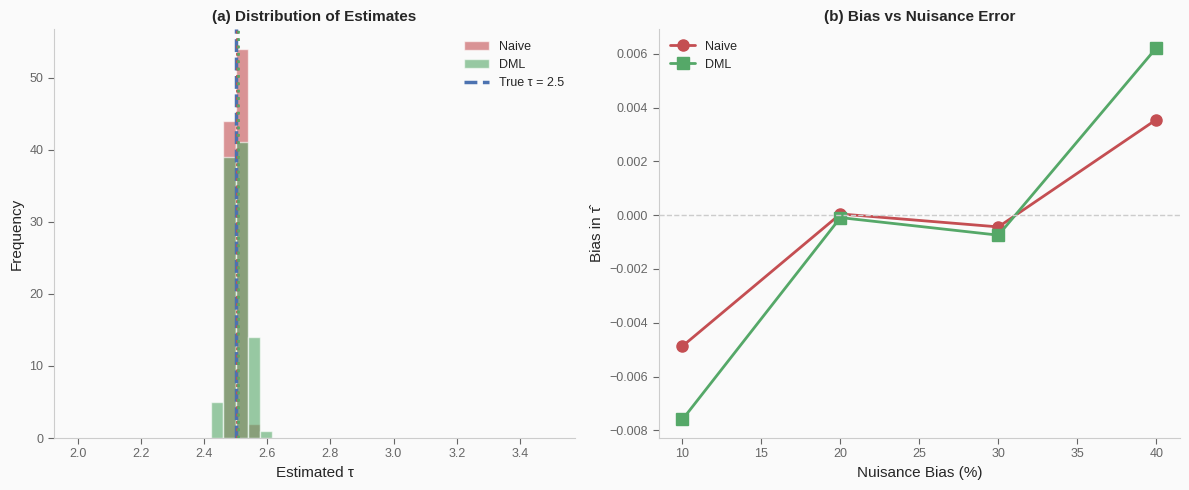

In [11]:
# Visualize distributions
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: Histograms
ax = axes[0]
bins = np.linspace(2.0, 3.5, 40)
ax.hist(naive_estimates, bins=bins, alpha=0.6, color=COLORS['red'], 
        label='Naive', edgecolor='white')
ax.hist(dml_estimates, bins=bins, alpha=0.6, color=COLORS['green'], 
        label='DML', edgecolor='white')
ax.axvline(true_tau, c=COLORS['blue'], ls='--', lw=2.5, label=f'True τ = {true_tau}')
ax.axvline(np.mean(naive_estimates), c=COLORS['red'], ls=':', lw=2)
ax.axvline(np.mean(dml_estimates), c=COLORS['green'], ls=':', lw=2)
ax.set_xlabel('Estimated τ', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('(a) Distribution of Estimates', fontweight='bold')
ax.legend(loc='upper right', frameon=False)

# Panel 2: Bias comparison across different bias levels (fewer points for speed)
ax = axes[1]
bias_levels = [0.1, 0.2, 0.3, 0.4]  # Reduced from 8 to 4 for speed
naive_biases = []
dml_biases = []

for bl in bias_levels:
    n_est, d_est, tt = run_simulation(n_sims=30, nuisance_bias=bl)
    naive_biases.append(np.mean(n_est) - tt)
    dml_biases.append(np.mean(d_est) - tt)

ax.plot([b*100 for b in bias_levels], naive_biases, 'o-', c=COLORS['red'], 
        lw=2, ms=8, label='Naive')
ax.plot([b*100 for b in bias_levels], dml_biases, 's-', c=COLORS['green'], 
        lw=2, ms=8, label='DML')
ax.axhline(0, c=TUFTE_PALETTE['spine'], ls='--', lw=1)
ax.set_xlabel('Nuisance Bias (%)', fontsize=11)
ax.set_ylabel('Bias in τ̂', fontsize=11)
ax.set_title('(b) Bias vs Nuisance Error', fontweight='bold')
ax.legend(loc='upper left', frameon=False)

plt.tight_layout()
plt.show()

---

## 6. Why Rates Matter

The practical implication of orthogonality involves **convergence rates**:

```
╔═══════════════════════════════════════════════════════════════╗
║                    CONVERGENCE RATES                          ║
╠═══════════════════════════════════════════════════════════════╣
║                                                               ║
║  For √n-consistent τ̂, we need nuisance errors small enough:  ║
║                                                               ║
║  Non-orthogonal:  ||η̂ - η₀|| = o_p(n^{-1/2})                 ║
║                   → Requires VERY fast rates (impossible ML) ║
║                                                               ║
║  Orthogonal:      ||η̂ - η₀|| = o_p(n^{-1/4})                 ║
║                   → Allows slower rates (achievable with ML!)║
║                                                               ║
╚═══════════════════════════════════════════════════════════════╝
```

### What Can ML Methods Achieve?

| Method | Typical Rate | Non-orthogonal? | Orthogonal? |
|--------|--------------|-----------------|-------------|
| OLS (correct spec) | $n^{-1/2}$ | ✓ Yes | ✓ Yes |
| Lasso | $n^{-1/4}$ to $n^{-1/3}$ | ✗ No | ✓ Yes |
| Random Forest | $n^{-1/4}$ to $n^{-1/3}$ | ✗ No | ✓ Yes |
| Neural Networks | $n^{-1/4}$ to $n^{-1/3}$ | ✗ No | ✓ Yes |

**Orthogonality unlocks ML for causal inference!**

/tmp/ipykernel_1152489/2060798987.py:23: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


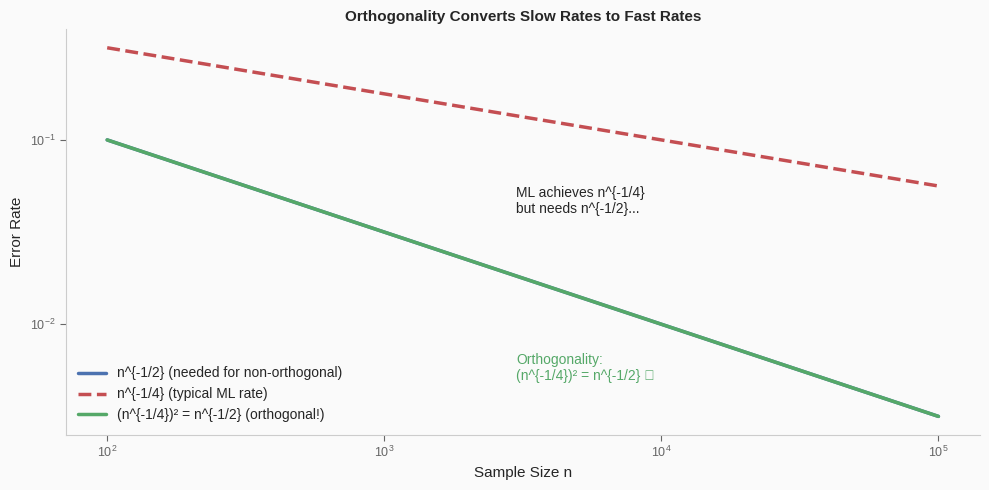

In [12]:
# Visualize convergence rates
n_values = np.logspace(2, 5, 50)  # 100 to 100,000

rate_fast = n_values**(-0.5)      # n^{-1/2}
rate_ml = n_values**(-0.25)       # n^{-1/4}
rate_ml_sq = rate_ml**2           # (n^{-1/4})^2 = n^{-1/2}

fig, ax = create_tufte_figure(1, 1, figsize=(10, 5))

ax.loglog(n_values, rate_fast, c=COLORS['blue'], lw=2.5, label='n^{-1/2} (needed for non-orthogonal)')
ax.loglog(n_values, rate_ml, c=COLORS['red'], lw=2.5, ls='--', label='n^{-1/4} (typical ML rate)')
ax.loglog(n_values, rate_ml_sq, c=COLORS['green'], lw=2.5, label='(n^{-1/4})² = n^{-1/2} (orthogonal!)')

ax.set_xlabel('Sample Size n', fontsize=11)
ax.set_ylabel('Error Rate', fontsize=11)
ax.set_title('Orthogonality Converts Slow Rates to Fast Rates', fontweight='bold')
ax.legend(loc='lower left', frameon=False, fontsize=10)

# Annotate
ax.annotate('ML achieves n^{-1/4}\nbut needs n^{-1/2}...', xy=(3000, 0.04), fontsize=10)
ax.annotate('Orthogonality:\n(n^{-1/4})² = n^{-1/2} ✓', xy=(3000, 0.005), fontsize=10, color=COLORS['green'])

plt.tight_layout()
plt.show()

---

## 7. Key Takeaways

```
★ Summary ──────────────────────────────────────────────────

1. PROBLEM: ML models are biased (regularization). Does this
   bias the treatment effect estimate?

2. NON-ORTHOGONAL SCORES: Yes! First-order nuisance errors
   directly translate to first-order bias in τ̂.

3. NEYMAN ORTHOGONALITY: A score property where:
   ∂/∂η E[ψ(W; τ₀, η)]|_{η₀} = 0
   
   → First-order nuisance errors have ZERO first-order effect

4. DML SCORE: (T - m̂(X)) · (Y - ℓ̂(X) - τ(T - m̂(X)))
   → Uses E[Y|X] instead of direct effect g(X)
   → Achieves orthogonality

5. RATES: Orthogonality allows n^{-1/4} nuisance rates
   to achieve n^{-1/2} target rates.
   → UNLOCKS ML FOR CAUSAL INFERENCE

6. REMAINING ISSUE: Overfitting when using same data for
   nuisance estimation and score evaluation.
   → Solved by cross-fitting (Notebook 04)
─────────────────────────────────────────────────────────────
```

---

## 8. Interview Appendix

**Q (Meta IC5, Economist)**: *"Why does DML work with biased ML estimators? Explain Neyman orthogonality intuitively."*

<details>
<summary>Solution</summary>

**Key points to hit:**

1. **The problem**: ML estimators (Random Forest, Lasso) are biased due to regularization. In a naive approach, this bias propagates to the treatment effect estimate.

2. **Intuition for orthogonality**: Think of the expected score $E[\psi]$ as a surface over the nuisance parameters. At the true values $\eta_0$:
   - Non-orthogonal: The surface has a non-zero slope. Moving slightly in any direction changes the score.
   - Orthogonal: The surface is **flat**. The gradient is zero. Small perturbations in nuisance have no first-order effect.

3. **Mathematical statement**: $\frac{\partial}{\partial \eta} E[\psi(W; \tau_0, \eta)]|_{\eta_0} = 0$

4. **Consequence for bias**:
   - Non-orthogonal: $\text{Bias}(\hat{\tau}) \propto \|\hat{\eta} - \eta_0\|$ (first-order)
   - Orthogonal: $\text{Bias}(\hat{\tau}) \propto \|\hat{\eta} - \eta_0\|^2$ (second-order, much smaller)

5. **Rate implication**: ML methods achieve rates like $n^{-1/4}$. With orthogonality, $(n^{-1/4})^2 = n^{-1/2}$, which is enough for $\sqrt{n}$-consistency.

6. **The DML trick**: Instead of using $g(X)$ (direct X→Y effect), use $\ell(X) = E[Y|X]$. Under the model, $\ell_0 = \tau_0 \cdot m_0 + g_0$, and this substitution achieves orthogonality.

**One-liner**: "Orthogonality makes the score insensitive to first-order nuisance errors, converting the bias from linear to quadratic in the error rate."

</details>

---

## 9. References

[^1]: Chernozhukov, V. et al. (2018). Double/Debiased Machine Learning for Treatment and Structural Parameters. *The Econometrics Journal*, 21(1), C1-C68.

[^2]: Neyman, J. (1959). Optimal Asymptotic Tests of Composite Statistical Hypotheses. *Probability and Statistics*.

[^3]: Bickel, P. J. et al. (1993). *Efficient and Adaptive Estimation for Semiparametric Models*. Johns Hopkins University Press.

---

**Next**: [03. The Regularization Problem](./03_regularization_problem.ipynb) — Why naive ML fails and how DML overcomes it